## 章节 9.3：IMDB评论分类（预处理好的字词数据集）
## Section 9.3: IMDB Reviews Classification with Preprocessing 
### 查看词的文档信息 [imdb_reviews/subwords8k](https://www.tensorflow.org/datasets/catalog/imdb_reviews#imdb_reviewssubwords8k)
### 进一步学习字词编码的信息: tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
imdb, info = tfds.load('imdb_reviews/subwords8k', with_info = True, as_supervised = True)

In [2]:
train_data, test_data = imdb['train'], imdb['test']
tokenizer = info.features['text'].encoder

sample_string = 'TensorFlow, from basics to mastery'
tokenized_string = tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [3]:
for ts in tokenized_string:
    print('{} ---> {}'.format(ts, tokenizer.decode([ts])))

6307 ---> Ten
2327 ---> sor
4043 ---> Fl
2120 ---> ow
2 ---> , 
48 ---> from 
4249 ---> basi
4429 ---> cs 
7 ---> to 
2652 ---> master
8050 ---> y


In [4]:
BUFFER_SIZE = 500 # 值越大，模型收敛的速度就越快，但过拟合就越快 小于1000最好
BATCH_SIZE = 50

train_data = train_data.shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE)

In [5]:
embedding_dim = 16 # 调大对模型精读几乎没有影响，反而会大大增加运算时间
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 131,069
Trainable params: 131,069
Non-trainable params: 0
_________________________________________________________________


In [6]:
num_epochs = 10
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_data, epochs=num_epochs, validation_data=test_data)

Epoch 1/10
500/500 [==============================] - 10s 18ms/step - loss: 0.6897 - accuracy: 0.5627 - val_loss: 0.6462 - val_accuracy: 0.7493
Epoch 2/10
500/500 [==============================] - 7s 14ms/step - loss: 0.5954 - accuracy: 0.7725 - val_loss: 0.4715 - val_accuracy: 0.8297
Epoch 3/10
500/500 [==============================] - 7s 14ms/step - loss: 0.4212 - accuracy: 0.8516 - val_loss: 0.3777 - val_accuracy: 0.8586
Epoch 4/10
500/500 [==============================] - 7s 14ms/step - loss: 0.3305 - accuracy: 0.8827 - val_loss: 0.3380 - val_accuracy: 0.8716
Epoch 5/10
500/500 [==============================] - 8s 15ms/step - loss: 0.2840 - accuracy: 0.8982 - val_loss: 0.3196 - val_accuracy: 0.8772
Epoch 6/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2539 - accuracy: 0.9103 - val_loss: 0.3108 - val_accuracy: 0.8790
Epoch 7/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2345 - accuracy: 0.9153 - val_loss: 0.3204 - val_accuracy: 0.869

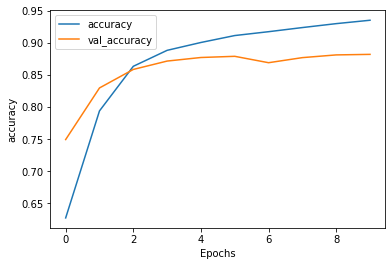

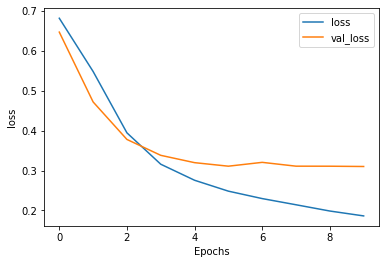

In [7]:
import matplotlib.pyplot as plt

def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graph(history, "accuracy")
plot_graph(history, "loss")

In [8]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(8185, 16)


In [9]:
out_v = open('9.3_imdb_views_vecs.tsv', 'w', encoding='utf-8')
out_m = open('9.3_imdb_views_meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, weights.shape[0]):
    word = tokenizer.decode([word_num])
    embeddings = weights[word_num]
    out_m.write(word+'\n')
    out_v.write('\t'.join([str(x) for x in embeddings])+'\n')

out_m.close()
out_v.close()

## 可视化结果
- 打开 http://projector.tensorflow.org/ 
- Load 9.3_imdb_reviews_vecs.tsv 和 9.3_imdb_reviews_meta.tsv文件
- 选择球面化
- 发现单词已经聚类向两侧了